In [10]:
# get Data ()
import pandas as pd
import numpy as np
import ast


# change csv for each 
persona_data = pd.read_csv("Results\TheBloke_Upstage-Llama-2-70B-instruct-v2-AWQ_persona_run.csv")
raw_data = pd.read_csv("Results\TheBloke_Upstage-Llama-2-70B-instruct-v2-AWQ_raw_run.csv" )


In [11]:
#add RawPartyID to raw_data
these_data = pd.read_excel('Data\Fulldata.xlsx')
for index, row in raw_data.iterrows():
    theseId = index + 1
    answer = round(row['Answer'])
    matching_rows = these_data[these_data['These: Nr.'] == theseId]
    rawPartyIds = []
    for match_row in matching_rows.iterrows():
        position = match_row[1]['Position: Position']
        partyId = match_row[1]['Partei: Nr.']
        if position == "stimme zu": 
            position_array = [4,5]
        elif position == "stimme nicht zu":
            position_array = [1,2]
        else:
            position_array = [3]
        if answer in position_array:
            rawPartyIds.append(partyId)
    raw_data.loc[index, 'RawPartyIds'] = str(rawPartyIds)
    



In [108]:
#filter for high variance
counter = 0
answerVariance = []        
filtered_indices = []
for index, raw_row in raw_data.iterrows():
    answers = ast.literal_eval(raw_row['AllAnswers'])
    variance = np.var(answers)
    answerVariance.append(raw_row['Answer'])
    if variance > 1.5:
        filtered_indices.append(index)
        counter += 1

# Remove corresponding rows from persona_data DataFrame
print(filtered_indices)
raw_data.drop(filtered_indices, inplace=True)
for i in range(len(filtered_indices)):
    filtered_indices[i] += 1
persona_data.drop(persona_data[persona_data['TheseId'].isin(filtered_indices)].index, inplace=True)
print(len(persona_data))
print(counter)
print(len(raw_data))  
print(np.var(answerVariance))  

[63]
5130
1
95
0.3668361506684952


In [13]:
#merge both datas to one
merged_data = pd.DataFrame(None, columns=["TheseId", "PartyId", "SourceId", "PartyPosition", "PersonaAnswer", "RawAnswer", "RawPartyIds"])
for index, raw_row in raw_data.iterrows():
    # theseId == index + 1
    filtered_persona_data = persona_data[persona_data['TheseId'] == index + 1].copy()
    #raw_answer = round(raw_row['Answer'])
    filtered_persona_data = pd.DataFrame(filtered_persona_data)
    for _, persona_row in filtered_persona_data.iterrows():
        persona_answer = persona_row['Answer']
        merged_data.loc[len(merged_data.index)] = {
            "TheseId": persona_row['TheseId'], 
            "PartyId": persona_row['PartyId'], 
            "SourceId": persona_row['SourceId'], 
            "PartyPosition": persona_row['PartyPosition'], 
            "PersonaAnswer": persona_answer, 
            "RawAnswer": raw_row['Answer'],
            "RawPartyIds": raw_row['RawPartyIds']
        }

        

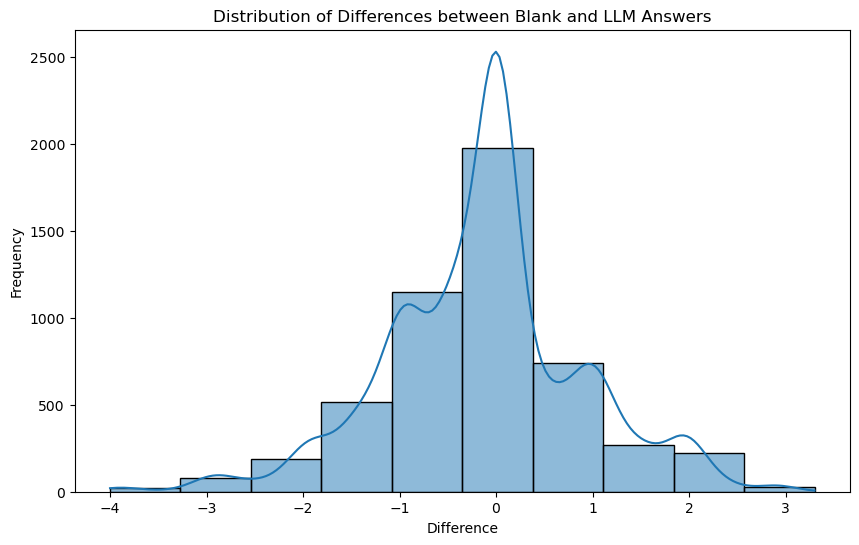

count    5184.000000
mean       -0.128164
std         1.028028
min        -4.000000
25%        -0.800000
50%        -0.100000
75%         0.300000
max         3.300000
Name: difference, dtype: float64


In [42]:
#hypothesis 1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

merged_data['difference'] = merged_data['RawAnswer'] - merged_data['PersonaAnswer']
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['difference'], bins=10, kde=True)
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Differences between Blank and LLM Answers')
plt.show()

# Summary statistics
print(merged_data['difference'].describe())

In [43]:
# determine switches for hypothesis 3
for index, row in merged_data.iterrows():
    if round(row['difference']) != 0:
        if row["PartyPosition"] == "stimme zu": 
            position = [4,5]
        elif row["PartyPosition"] == "stimme nicht zu":
            position = [1,2]
        else:
            position = [3]
        if row['PersonaAnswer'] in position and round(row['RawAnswer']) not in position:
            merged_data.loc[index, 'switch'] = True
        else:
            merged_data.loc[index, 'switch'] = False
    else:
            merged_data.loc[index, 'switch'] = False


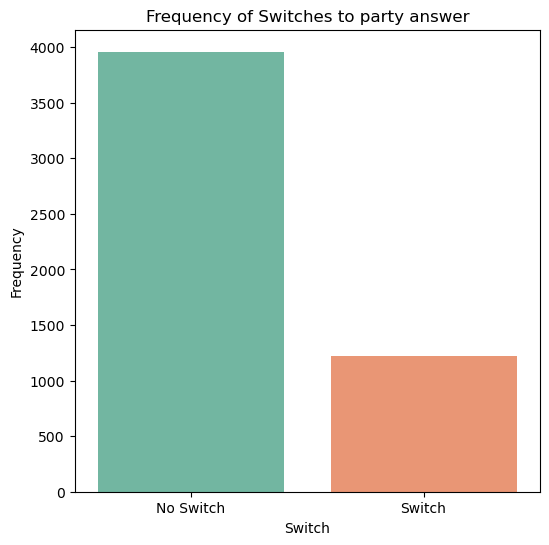

Percentage of switches: 23.63%
Percentage of no switches: 76.37%


In [44]:
#hypothesis 3
switch_counts = merged_data['switch'].value_counts()

# Visualize the frequency of switches
plt.figure(figsize=(6, 6))
sns.countplot(data=merged_data, x='switch', palette='Set2')
plt.xlabel('Switch')
plt.ylabel('Frequency')
plt.title('Frequency of Switches to party answer')
plt.xticks([0, 1], ['No Switch', 'Switch'])
plt.show()

# Calculate the percentage of switches
total_switches = switch_counts[True] if True in switch_counts else 0
total_no_switches = switch_counts[False] if False in switch_counts else 0
total_rows = len(merged_data)

percentage_switches = (total_switches / total_rows) * 100
percentage_no_switches = (total_no_switches / total_rows) * 100

print("Percentage of switches: {:.2f}%".format(percentage_switches))
print("Percentage of no switches: {:.2f}%".format(percentage_no_switches))

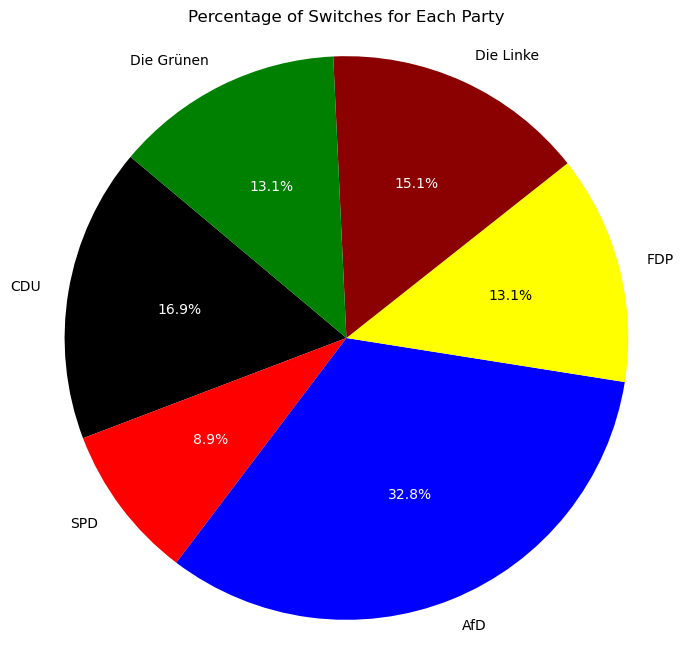

Percentage of switches for each party:
PartyId
1    23.958333
2    12.615741
3    46.527778
4    18.634259
5    21.412037
6    18.634259
dtype: float64


In [45]:
from matplotlib.colors import to_rgb

party_mapping = {
    1: {'name': 'CDU', 'color': 'black'},
    2: {'name': 'SPD', 'color': 'red'},
    3: {'name': 'AfD', 'color': 'blue'},
    4: {'name': 'FDP', 'color': 'yellow'},
    5: {'name': 'Die Linke', 'color': 'darkred'},
    6: {'name': 'Die Grünen', 'color': 'green'}
}
merged_data['PartyName'] = merged_data['PartyId'].map(lambda x: party_mapping[x]['name'])
merged_data['PartyColor'] = merged_data['PartyId'].map(lambda x: party_mapping[x]['color'])

# Group the data by PartyId and calculate the frequency of switches for each party
party_switch_counts = merged_data.groupby('PartyId')['switch'].value_counts().unstack(fill_value=0)

# Calculate the total number of responses for each party
party_total_counts = merged_data['PartyId'].value_counts()

# Calculate the percentage of switches for each party
party_switch_percentages = (party_switch_counts[True] / party_total_counts) * 100

def get_text_color(background_color):
    rgb = to_rgb(background_color)
    # Convert background color to grayscale
    grayscale = 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
    # Determine text color based on grayscale value
    if grayscale > 0.5:
        return 'black'  # Use black text for light backgrounds
    else:
        return 'white'  # Use white text for dark backgrounds

background_colors = [party_mapping[i]['color'] for i in party_switch_percentages.index]
text_colors = [get_text_color(background_color) for background_color in background_colors]
# Visualize the percentage of switches for each party using a pie chart with colors
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    party_switch_percentages, 
    labels=party_switch_percentages.index.map(lambda x: party_mapping[x]['name']), 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=background_colors
)

# Set text color dynamically based on background color
for autotext, background_color in zip(autotexts, background_colors):
    autotext.set_color(get_text_color(background_color))

plt.title('Percentage of Switches for Each Party')
plt.axis('equal')
plt.show()


# Display the percentage of switches for each party
print("Percentage of switches for each party:")
print(party_switch_percentages)


In [46]:
real_politicians_data = merged_data[merged_data['SourceId'] == 5]

other_personas_data = merged_data[merged_data['SourceId'].isin([1, 2, 3, 4])]

# Calculate the total number of responses for each group
total_responses_real_politicians = len(real_politicians_data)
total_responses_other_personas = len(other_personas_data)

# Calculate the number of switches for each group
switches_real_politicians = real_politicians_data['switch'].sum()
switches_other_personas = other_personas_data['switch'].sum()
print(len(real_politicians_data), switches_real_politicians)
print(len(other_personas_data) , switches_other_personas)
all_switches = switches_real_politicians + switches_other_personas
# Calculate the switch frequencies
real_politicians_switch_frequency = (switches_real_politicians / all_switches) * 100
other_personas_switch_frequency = (switches_other_personas / all_switches) * 100

# Compare the switch frequencies between the two groups
print("Switch frequency for PersonaAnswers based on real politicians (SourceId == 5): {:.2f}%".format(real_politicians_switch_frequency))
print("Switch frequency for other PersonaAnswers (SourceId 1-4): {:.2f}%".format(other_personas_switch_frequency))


2880 669
2304 556
Switch frequency for PersonaAnswers based on real politicians (SourceId == 5): 54.61%
Switch frequency for other PersonaAnswers (SourceId 1-4): 45.39%


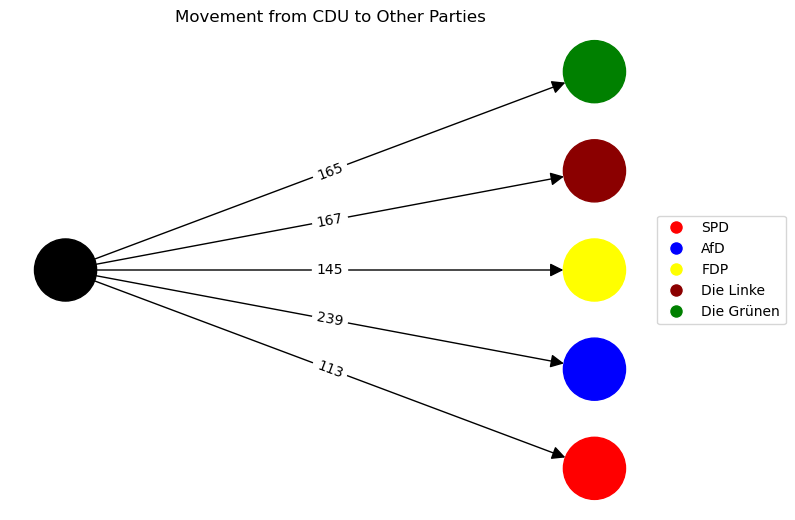

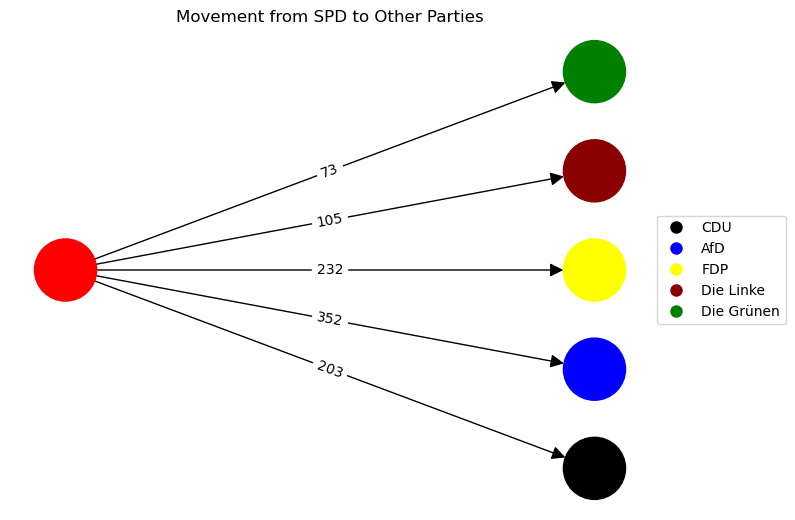

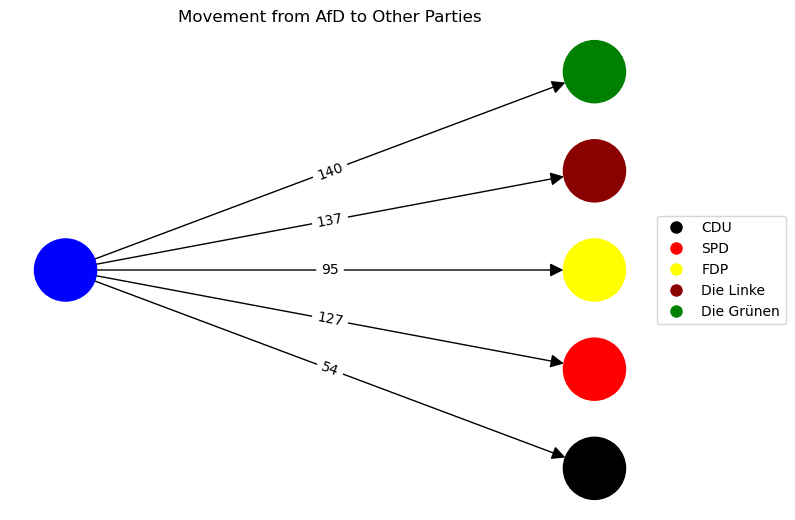

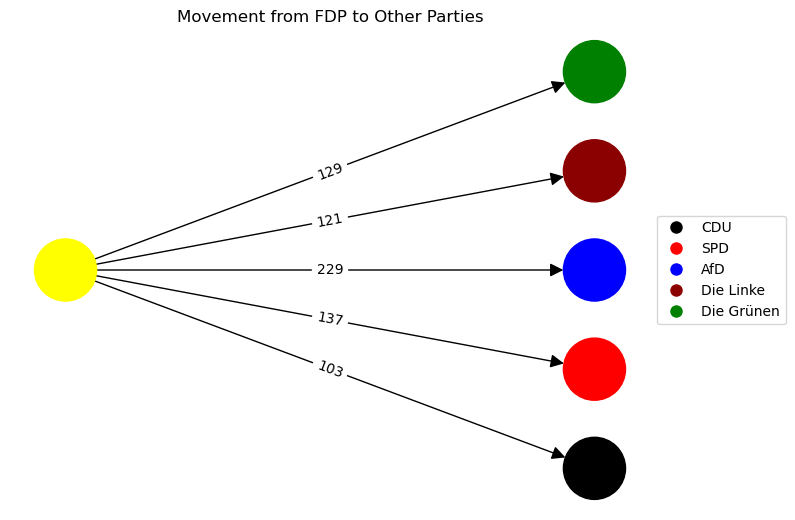

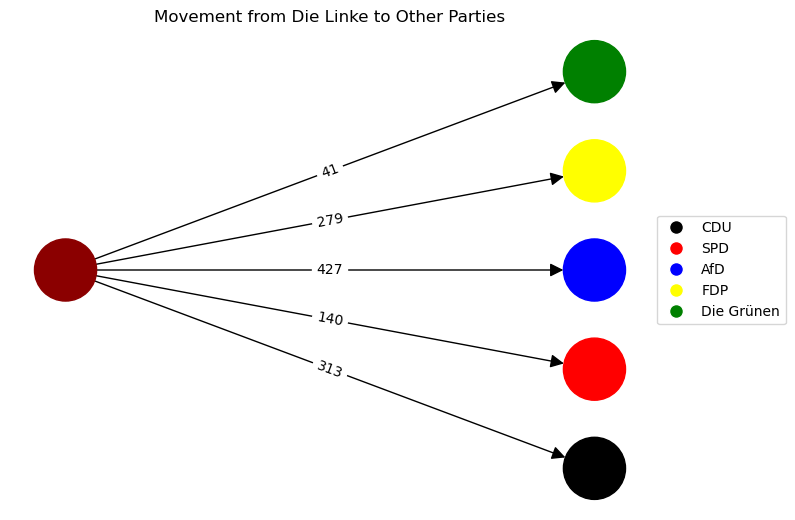

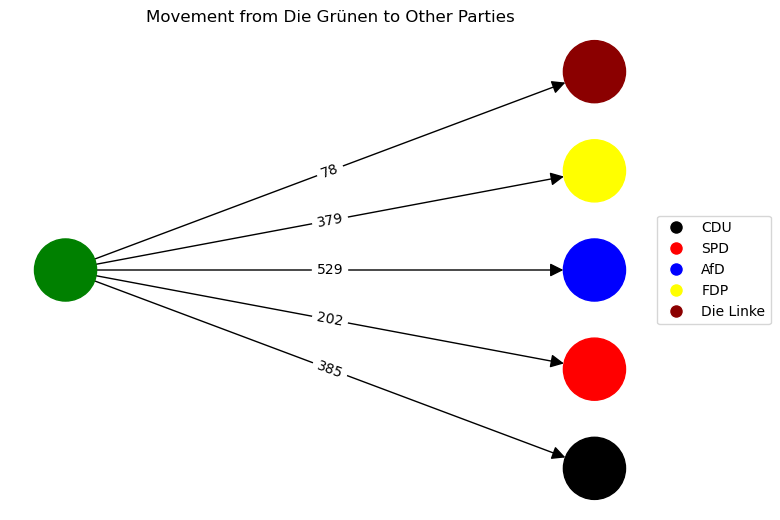

In [64]:
#voter movement
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

voter_movement = []
for index, row in merged_data.iterrows():
    persona_answer = row["PersonaAnswer"]
    raw_answer = round(row["RawAnswer"])
    if(persona_answer != raw_answer):
        approve = {4,5}
        disapprove = {1,2}
        neutral = {3}
        if {persona_answer, raw_answer} not in [approve, disapprove, neutral]:
            matching_rows = these_data[these_data['These: Nr.'] == row["TheseId"]]
            for _, match_row in matching_rows.iterrows():
                position = match_row['Position: Position']
                partyId = match_row['Partei: Nr.']
                if position == "stimme zu": 
                    position_array = [4,5]
                elif position == "stimme nicht zu":
                    position_array = [1,2]
                else:
                    position_array = [3]
                if raw_answer not in position_array and persona_answer in position_array:
                    rawPartyIds = ast.literal_eval(row['RawPartyIds'])
                    for id in rawPartyIds:
                        voter_movement.append((id, partyId))
                        
voter_movement_graph = nx.DiGraph()

for party_id in range(1, 7):
    # Initialize an empty graph for the current party movement
    voter_movement_graph = nx.DiGraph()

    # Add nodes for the current party and parties 1 and 3 to 6 with respective colors and labels
    voter_movement_graph.add_node(
        party_id, pos=(0, 3),
        color=party_mapping[party_id]['color']
    )
    positions_stack = [1, 2, 3, 4, 5]
    for party in range(1, 7):
        if party != party_id:
            voter_movement_graph.add_node(
                party, 
                pos=(3, positions_stack.pop(0)),
                color=party_mapping[party]['color']
            )

    # Add edges for the movement from the current party to parties 1 and 3 to 6
    for party_to in range(1, 7):
        if party_to != party_id:
            voter_movement_graph.add_edge(
                party_id, 
                party_to, 
                weight=sum(1 for edge in voter_movement if edge[1] == party_to and edge[0] == party_id)
            )

    # Define custom positions for nodes
    positions = nx.get_node_attributes(voter_movement_graph, 'pos')

    # Define node colors
    node_colors = [party_mapping[node]['color'] for node in voter_movement_graph.nodes]

    # Visualize the graph with customized node positions, colors, and labels
    nx.draw(
        voter_movement_graph,
        pos=positions, 
        with_labels=True, 
        labels=nx.get_node_attributes(voter_movement_graph, 'label'),
        node_color=node_colors, 
        node_size=2000, 
        arrowsize=20
    )

    # Create legend
    legend_elements = [
        Line2D([0], 
        [0], 
        marker='o', 
        color='w', 
        label=party_mapping[party]['name'],
        markerfacecolor=party_mapping[party]['color'], 
        markersize=10) 
        for party in range(1, 7) if party != party_id
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

    # Add edge labels
    edge_labels = {(party_id, party_to): str(voter_movement_graph[party_id][party_to]['weight']) for party_to in range(1, 7) if party_to != party_id}
    nx.draw_networkx_edge_labels(
        voter_movement_graph, 
        pos=positions, 
        edge_labels=edge_labels
    )

    plt.title(f"Movement from {party_mapping[party_id]['name']} to Other Parties")
    plt.show()
